# Data Wrangling - 311 Data


### I. Summary of the Data
The data used in this project was gathered from a few different sources. Information was accessed with an API or downloaded as CSV files. The data was cleaned and consolidated into a single CSV file, ready for further analysis and modeling.

_Minneapolis 311 Open Dataset (2016-2018)_  
**Annual 311 service request data** was available from the City of Minneapolis Open Data website. The data for 2017 and 2018 data was collected as a JSON file through an API. The 2016 dataset was downloaded as a CSV file.
* **Source:** http://opendata.minneapolismn.gov/datasets?t=311
* **File:** 311_Incidents_2016.csv
         
_Historical Climate Data for Minneapolis (2016-2018)_  
**Daily historical climate data** was collected as a CSV file from the Minnesota Department of Natural Resources.
* **Source:** https://www.dnr.state.mn.us/climate/historical/summary.html
* **File:**  Climate_Data_16_17.csv


### II. Cleaning and Consolidating the Data
In order to consolidate 311 data from different years (and different file formats), column headers and timestamp formats were standardized. Some unnecessary attributes such as Case ID and Enquiry ID were dropped to reduce dimensionality. A new feature, called Days_Open, was engineered by calculating the number of days before each case was closed. The timestamps in the 311 data included the date and time, however, the climate data was recorded per day. The date each 311 case was opened was extracted from the timestamp so that the data frames could be merged on that feature. 


### III. Missing Values
Although neither dataset had missing values, there were a few inconsistencies in notation that were adjusted for ease of future analysis.  

- One 311 case (a parking violation) had an opening time stamp 3 seconds after it was closed. The time stamps were left as they were, but the Days_Open value was updated to be 1 (the minimum number of days). 
- The climate data contained some entries of “T”, indicating there were “trace amounts” of precipitation, snowfall or snow accumulation (depth). To convert “T” to a numerical value, it was replaced with 0.05 or 0.005 (inches).

### IV. Outliers
- Some 311 call types tended to have large clusters of cases all closed on the same date. These clusters occurred most notably for Sidewalk Snow & Ice Complaints, Exterior Nuisance Complaints, Private Property - Residential Conditions, and Hoarding Complaints. It’s unclear if these close dates are accurate, or were filled in to avoid missing values.

After cleaning and consolidating the data, it was converted to the CSV file listed below.
* 311_clean.csv



In [1]:
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import folium
from folium import plugins
import json
import geojson

## 311 Data - 2016

The API for 2016 data returned only 1000 out of 51k rows. The 'exceededTransferLimit' line of the data was listed as "True". As an alternative, the data was downloaded as a CSV file.

In [2]:
df16 = pd.read_csv("311_Incidents_2016.csv")
df16.head(2)

,X,Y,CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,LastUpdateDate,OBJECTID
0,-93.235927,44.931412,101003863139,101000085,Streets,Street Maintenance,General Street Complaint,General Street Complaint,2016-03-18T08:54:34.000Z,0,2016-03-21T06:57:34.000Z,-1.037898e+07,5.610730e+06,2018-03-13T10:24:55.000Z,3001
1,-93.255669,44.988227,101003863146,101002181,Public Safety,Graffiti / Clean City,Graffiti - Open311,Graffiti - Open311,2016-03-18T09:02:08.000Z,0,2016-03-23T09:37:03.000Z,-1.038117e+07,5.619668e+06,2018-03-13T10:24:55.000Z,3002


In [3]:
# Standardize column names
new_col_names = [ 'x_geom', 'y_geom', 'case_id', 'enquiry_type_id',
                 'subject', 'reason', 'complaint_type', 'title',
                 'opened_date', 'status', 'closed_date', 
                 'x_coord', 'y_coord', 'last_update', 'object_id']
df16.columns = new_col_names

# Convert dates to pandas datetime format.
df16['opened_date'] = pd.to_datetime(df16['opened_date'], format='%Y-%m-%dT%H:%M:%S')
df16['closed_date'] = pd.to_datetime(df16['closed_date'], format='%Y-%m-%dT%H:%M:%S')

## 311 Data - 2017

In [4]:
# Pull data from API - 311 2017
url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Public_311_2017/FeatureServer/0/query?where=1%3D1&outFields=CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,OBJECTID&outSR=4326&f=json'
r = requests.get(url)
api_json_data = r.json()
data_entries = api_json_data['features']

# Normalize the JSON data to populate tables from nested element
df17 = json_normalize(data_entries)

df17.head(2)

,attributes.CASEID,attributes.CASESTATUS,attributes.CLOSEDDATETIME,attributes.ENQUIRYTYPEID,attributes.OBJECTID,attributes.OPENEDDATETIME,attributes.REASONNAME,attributes.SUBJECTNAME,attributes.TITLE,attributes.TYPENAME,attributes.XCOORD,attributes.YCOORD,geometry.x,geometry.y
0,101004067850,0,1.502965e+12,101000108,1,1502923353000,Traffic Control,Vehicles and Commuting,Abandoned Vehicle,Abandoned Vehicle,-1.038153e+07,5.613039e+06,-93.258830,44.946091
1,101004067853,0,1.502962e+12,101000381,2,1502953724000,Animal Control,Animal Related,Animal Complaint - Public Health,Animal Complaint - Public Health,-1.037977e+07,5.623440e+06,-93.243016,45.012184


In [5]:
# Create new column names
new_col_names = ['case_id','status', 'closed_date', 'enquiry_type_id', 'object_id', 
                 'opened_date', 'reason', 'subject', 'title', 'complaint_type', 
                 'x_coord', 'y_coord', 'x_geom', 'y_geom']

# Rename columns
df17.columns = new_col_names

# Convert 'opened_date' values to datetime objects
df17['opened_date'] = df17['opened_date'].apply(lambda x: dt.datetime.fromtimestamp(x/1000).isoformat())

# Convert 'closed_date' values to datetime objects, unless NaN
df17['closed_date'] = df17['closed_date'].apply(lambda x: dt.datetime.fromtimestamp(x/1000).isoformat() 
                                               if pd.notnull(x) else x)

# Convert dates to pandas datetime format.
df17['opened_date'] = pd.to_datetime(df17['opened_date'], format='%Y-%m-%dT%H:%M:%S')
df17['closed_date'] = pd.to_datetime(df17['closed_date'], format='%Y-%m-%dT%H:%M:%S')

df17.head(2)

,case_id,status,closed_date,enquiry_type_id,object_id,opened_date,reason,subject,title,complaint_type,x_coord,y_coord,x_geom,y_geom
0,101004067850,0,2017-08-17 05:24:53,101000108,1,2017-08-16 17:42:33,Traffic Control,Vehicles and Commuting,Abandoned Vehicle,Abandoned Vehicle,-1.038153e+07,5.613039e+06,-93.258830,44.946091
1,101004067853,0,2017-08-17 04:28:08,101000381,2,2017-08-17 02:08:44,Animal Control,Animal Related,Animal Complaint - Public Health,Animal Complaint - Public Health,-1.037977e+07,5.623440e+06,-93.243016,45.012184


## Combine 2016 and 2017
* Append 2017 data onto 2016 data.
* Create a new column called Days_Open, calculated from the difference between the opened date and closed date.
* Set the opened_date column as the index.

In [6]:
# Re-order the 2016 columns to align with the 2017 dataframe.
df16 = df16[list(df17.columns)]

# Combine 2016 and 2017 call data
df1617 = df16.append(df17)

# Function to calculate the number of days between when each case was opened and closed.
# Added 1 to number of days open. If a case is closed within 24 hours, days_open = 1.
def days_open(row):
    if pd.notnull(row['closed_date']):
        date_cl = row['closed_date']
        date_op = row['opened_date']
        diff = date_cl - date_op
        return int(diff.days) + 1
    else:
        return np.nan

# Create new column that lists the number of days each case was open.
df1617['days_open'] = df1617.apply(lambda row: days_open(row), axis=1)

# Sort by opened_date
df1617 = df1617.sort_values(by = 'opened_date')

# Set the opened date as the index.
df1617 = df1617.set_index('opened_date')

df1617.head(2)

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,complaint_type,x_coord,y_coord,x_geom,y_geom,days_open
opened_date,,,,,,,,,,,,,,
2016-01-01 00:10:35,101003839191,0,2016-01-02 12:03:41,101002221,2196,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,-1.038160e+07,5.613667e+06,-93.259481,44.950087,2.0
2016-01-01 07:50:34,101003839192,0,2016-01-02 09:08:54,101002281,29550,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038520e+07,5.616158e+06,-93.291802,44.965918,2.0


In [7]:
# Check columns and entry types
df1617.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106928 entries, 2016-01-01 00:10:35 to 2017-12-31 06:56:54
Data columns (total 14 columns):
case_id            106928 non-null int64
status             106928 non-null int64
closed_date        106325 non-null datetime64[ns]
enquiry_type_id    106928 non-null int64
object_id          106928 non-null int64
reason             106928 non-null object
subject            106928 non-null object
title              106928 non-null object
complaint_type     106928 non-null object
x_coord            106928 non-null float64
y_coord            106928 non-null float64
x_geom             106928 non-null float64
y_geom             106928 non-null float64
days_open          106325 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(4), object(4)
memory usage: 12.2+ MB


## 311 Data - 2018

This data is updated daily, and will be kept separate from the 2016 and 2017 data.

In [8]:
#Read 311 Data - 2018
url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Public_311_2018_YTD/FeatureServer/0/query?where=1%3D1&outFields=CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,OBJECTID&outSR=4326&f=json'
r = requests.get(url)
api_json_data = r.json()

data_entries = api_json_data['features']
df18 = json_normalize(data_entries)

In [9]:
# Standardize column names 
new_col_names = ['case_id', 'status', 'closed_date', 'enquiry_type_id', 'object_id', 
                 'opened_date', 'reason', 'subject', 'title', 'complaint_type', 
                 'x_coord', 'y_coord', 'x_geom', 'y_geom']
df18.columns = new_col_names

# Convert 'OpenDateTime' values to datetime objects
df18['opened_date'] = df18['opened_date'].apply(lambda x: dt.datetime.fromtimestamp(x/1000).isoformat())
# Convert 'CloseDateTime' values to datetime objects, unless NaN
df18['closed_date'] = df18['closed_date'].apply(lambda x: dt.datetime.fromtimestamp(x/1000).isoformat() 
                                               if pd.notnull(x) else x)

# Convert dates to pandas datetime format.
df18['opened_date'] = pd.to_datetime(df18['opened_date'], format='%Y-%m-%dT%H:%M:%S')
df18['closed_date'] = pd.to_datetime(df18['closed_date'], format='%Y-%m-%dT%H:%M:%S')

# Create new column that lists the number of days each case was open. 
df18['days_open'] = df18.apply(lambda row: days_open(row), axis=1)

# Sort by opened_date
df18 = df18.sort_values(by = 'opened_date')

# Set the opened date as the index.
df18 = df18.set_index('opened_date')
df18.head(2)

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,complaint_type,x_coord,y_coord,x_geom,y_geom,days_open
opened_date,,,,,,,,,,,,,,
2017-12-31 18:05:00,101004120778,0,2018-01-02 02:38:36,101002181,37150,Graffiti / Clean City,Public Safety,Graffiti - Open311,Graffiti - Open311,-1.038604e+07,5.608372e+06,-93.299350,44.916415,2.0
2017-12-31 21:37:13,101004120779,0,2018-01-01 13:26:45,101002281,37152,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038293e+07,5.614953e+06,-93.271489,44.958263,1.0


## Climate data
Historical climate data from the State of Minnesota. Columns include:
* Maximum Temperature (F)
* Minimum Temperature (F)
* Precipitation (Inches)
* Snow Fall (Inches)
* Snow Depth (Inches)

In [10]:
df_weather = pd.read_csv("Climate_Data_16_17.csv", index_col = 'Date', parse_dates = True)

# Standardize column names 
new_col_names = ['max_temp', 'min_temp', 'precipitation', 'snow', 'snow_depth']
df_weather.columns = new_col_names

df_weather.head()  # T = trace amounts

,max_temp,min_temp,precipitation,snow,snow_depth
Date,,,,,
2016-01-01,30,15,T,T,4
2016-01-02,31,14,0,0,4
2016-01-03,29,20,0,0,4
2016-01-04,26,10,0,0,4
2016-01-05,32,20,0,0,4


In [11]:
# Check for missing values and discrepancies in formatting
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 933 entries, 2016-01-01 to 2018-07-21
Data columns (total 5 columns):
max_temp         933 non-null int64
min_temp         933 non-null int64
precipitation    933 non-null object
snow             933 non-null object
snow_depth       933 non-null object
dtypes: int64(2), object(3)
memory usage: 43.7+ KB


In [12]:
df_weather['precipitation'].value_counts(dropna=False).head()

0       474
T       147
0.01     43
0.02     21
0.04     16
Name: precipitation, dtype: int64

In [13]:
df_weather['snow'].value_counts(dropna=False).head()

0      763
T       86
0.1     14
0.3      8
0.6      7
Name: snow, dtype: int64

In [14]:
df_weather['snow_depth'].value_counts(dropna=False).head()

0    658
2     62
1     46
T     43
5     42
Name: snow_depth, dtype: int64

In [15]:
# Some precipitation, snow, and snow depth entries are "T" for "trace amounts".
# Current minimum values in each column are 0.01 inches (precipitation, snow) and 0.1 inches (snow depth).
# Replace these "T" values with a half increment.

df_weather.precipitation = df_weather.precipitation.replace('T', 0.005)
df_weather.snow = df_weather.snow.replace('T', 0.005)
df_weather.snow_depth = df_weather.snow_depth.replace('T', 0.05)

# Coerce the values into numeric types, after removing any string values.

df_weather.precipitation = pd.to_numeric(df_weather.precipitation)
df_weather.snow = pd.to_numeric(df_weather.snow)
df_weather.snow_depth = pd.to_numeric(df_weather.snow_depth)

# Check entry types are correct
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 933 entries, 2016-01-01 to 2018-07-21
Data columns (total 5 columns):
max_temp         933 non-null int64
min_temp         933 non-null int64
precipitation    933 non-null float64
snow             933 non-null float64
snow_depth       933 non-null float64
dtypes: float64(3), int64(2)
memory usage: 43.7 KB


## Combine 311 and Climate Dataframes
* Separate the date and time values from the opened_date index. These will be saved in new columns called 'open_day' and 'open_time'.
* Use multi indexing to isolate the date each case was opened.
* Merge the climate data and 311 data by matching the opened date.

In [16]:
# Need to create date column in order to combine with weather data.
df1617['open_day'] = df1617.index.date
df1617['open_time'] = df1617.index.time

#Isolate month and year each case was closed
df1617['closed_year'] = df1617['closed_date'].dt.year
df1617['closed_month'] = df1617['closed_date'].dt.month

#Isolate month and year each case was opened
df1617['opened_year'] = df1617.index.year
df1617['opened_month'] = df1617.index.month

#df1617.index = pd.MultiIndex.from_arrays([df1617.index.date, df1617.index.time], names=['Date','Time'])
df1617.index = pd.MultiIndex.from_arrays([df1617.index.date, df1617.index.time], names=['Date','Time'])


In [17]:
# Check whether title and complaint_type are identical, and one can be removed.
list(df1617.title) == list(df1617.complaint_type)

True

In [18]:
#Combine dataframes: 311 and weather 
df1617weather = pd.merge(df1617, df_weather, left_index=True, right_index=True, how = 'left')

# Re-order the columns for better viewing. 
# Remove unused features ('case_id', 'enquiry_id', 'complaint_type')
df1617weather = df1617weather[['status', 'closed_date', 'days_open', 
                              'reason', 'subject', 'title', 'object_id', 
                              'x_coord', 'y_coord', 'x_geom', 'y_geom', 
                              'opened_year', 'opened_month', 'open_day', 'open_time', 
                              'closed_year', 'closed_month', 'max_temp', 'min_temp', 
                              'precipitation', 'snow', 'snow_depth']]

df1617weather.head(2)

status         closed_date  days_open           reason  \
Date       Time                                                               
2016-01-01 00:10:35       0 2016-01-02 12:03:41        2.0  Traffic Control   
           07:50:34       0 2016-01-02 09:08:54        2.0  Traffic Control   

                                    subject                        title  \
Date       Time                                                            
2016-01-01 00:10:35  Vehicles and Commuting  Abandoned Vehicle - Open311   
           07:50:34  Vehicles and Commuting  Parking Violation - Open311   

                     object_id       x_coord       y_coord     x_geom  \
Date       Time                                                         
2016-01-01 00:10:35       2196 -1.038160e+07  5.613667e+06 -93.259481   
           07:50:34      29550 -1.038520e+07  5.616158e+06 -93.291802   

                        ...      opened_month    open_day  open_time  \
Date       Time         ...                                            
2016-01-01 00:10:35     ...                 1  2016-01-01   00:10:35   
           07:50:34     ...                 1  2016-01-01   07:50:34   

                    closed_year closed_month  max_temp  min_temp  \
Date       Time                                                    
2016-01-01 00:10:35      2016.0          1.0        30        15   
           07:50:34      2016.0          1.0        30        15   

                     precipitation   snow  snow_depth  
Date       Time                                        
2016-01-01 00:10:35          0.005  0.005         4.0  
           07:50:34          0.005  0.005         4.0  

[2 rows x 22 columns]

## Export Clean Data as a CSV file

In [19]:
df1617weather.to_csv('311_clean.csv')

## Outliers and Missing Values

In [20]:
# Read the csv data file from above.
df = pd.read_csv('311_clean.csv', index_col=[0,1], parse_dates = ['Date', 'closed_date', 'open_day'])
df.head(2)

status         closed_date  days_open           reason  \
Date       Time                                                               
2016-01-01 00:10:35       0 2016-01-02 12:03:41        2.0  Traffic Control   
           07:50:34       0 2016-01-02 09:08:54        2.0  Traffic Control   

                                    subject                        title  \
Date       Time                                                            
2016-01-01 00:10:35  Vehicles and Commuting  Abandoned Vehicle - Open311   
           07:50:34  Vehicles and Commuting  Parking Violation - Open311   

                     object_id       x_coord       y_coord     x_geom  \
Date       Time                                                         
2016-01-01 00:10:35       2196 -1.038160e+07  5.613667e+06 -93.259481   
           07:50:34      29550 -1.038520e+07  5.616158e+06 -93.291802   

                        ...      opened_month   open_day  open_time  \
Date       Time         ...                                           
2016-01-01 00:10:35     ...                 1 2016-01-01   00:10:35   
           07:50:34     ...                 1 2016-01-01   07:50:34   

                    closed_year closed_month  max_temp  min_temp  \
Date       Time                                                    
2016-01-01 00:10:35      2016.0          1.0        30        15   
           07:50:34      2016.0          1.0        30        15   

                     precipitation   snow  snow_depth  
Date       Time                                        
2016-01-01 00:10:35          0.005  0.005         4.0  
           07:50:34          0.005  0.005         4.0  

[2 rows x 22 columns]

## Search for Outliers

In [21]:
df.describe()

,status,days_open,object_id,x_coord,y_coord,x_geom,y_geom,opened_year,opened_month,closed_year,closed_month,max_temp,min_temp,precipitation,snow,snow_depth
count,106928.000000,106325.000000,106928.000000,1.069280e+05,1.069280e+05,1.069280e+05,1.069280e+05,106928.000000,106928.000000,106325.000000,106325.000000,106928.000000,106928.000000,106928.000000,106928.000000,106928.000000
mean,0.005639,11.259149,26759.527533,-9.607225e+06,5.196746e+06,-8.630317e+01,4.160782e+01,2016.515889,6.639692,2016.552523,6.492462,60.202660,43.410267,0.106029,0.063588,0.527504
std,0.074884,31.301559,15480.518465,2.729446e+06,1.476424e+06,2.451903e+01,1.182098e+01,0.499750,3.273724,0.548467,3.279049,22.375392,20.303351,0.287227,0.422753,1.415929
min,0.000000,0.000000,1.000000,-1.038935e+07,0.000000e+00,-9.332915e+01,-1.280796e-14,2016.000000,1.000000,2016.000000,1.000000,-6.000000,-20.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,13366.750000,-1.038512e+07,5.610720e+06,-9.329116e+01,4.493135e+01,2016.000000,4.000000,2016.000000,4.000000,41.000000,29.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,26732.500000,-1.038250e+07,5.614949e+06,-9.326761e+01,4.495823e+01,2017.000000,7.000000,2017.000000,7.000000,66.000000,47.000000,0.000000,0.000000,0.000000
75%,0.000000,7.000000,40098.250000,-1.037922e+07,5.620285e+06,-9.323808e+01,4.499214e+01,2017.000000,9.000000,2017.000000,9.000000,79.000000,61.000000,0.040000,0.000000,0.000000
max,1.000000,550.000000,55164.000000,0.000000e+00,5.629593e+06,2.544444e-14,4.505124e+01,2017.000000,12.000000,2018.000000,12.000000,97.000000,77.000000,2.180000,8.800000,9.000000


In [22]:
# Inspect case(s) open for 0 days. 
df[df['days_open'] == 0] 

,,status,closed_date,days_open,reason,subject,title,object_id,x_coord,y_coord,x_geom,...,opened_month,open_day,open_time,closed_year,closed_month,max_temp,min_temp,precipitation,snow,snow_depth
Date,Time,,,,,,,,,,,,,,,,,,,,,
2017-10-30,08:40:03,0,2017-10-30 08:40:00,0.0,Traffic Control,Vehicles and Commuting,Parking Violation Complaint,46556,-1.037889e+07,5.613397e+06,-93.235147,...,10,2017-10-30,08:40:03,2017.0,10.0,40,31,0.005,0.005,0.0


#### Case was closed 3 seconds before it was opened. Replace 'days_open' value with 1 (the minimum count we're using).

In [23]:
# Replace 0 value in 'days_open' column with 1.
df.days_open = df.days_open.replace(0, 1) 

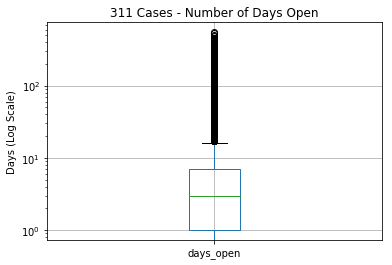

In [24]:
# View box plot of number of days open, to visually inspect outliers
df1617.boxplot(column='days_open')
plt.yscale('log')
plt.title('311 Cases - Number of Days Open')
plt.ylabel('Days (Log Scale)')
plt.show()

### Outliers
The 75th percentile is 7 days, for number of days each case is open. This implies any case open longer than a week is an outlier. This will need to be examined for each type of case during EDA.

## Search for Missing Values

In [25]:
top_close = df.closed_date.value_counts(dropna=False).head(10)
top_close

NaT                    603
2018-01-29 07:41:25    100
2018-01-29 07:39:05    100
2017-03-31 08:45:18     95
2018-01-29 07:36:39     95
2018-01-29 08:26:09     91
2017-03-31 13:45:55     91
2017-10-31 12:34:48     84
2017-03-31 13:47:49     68
2018-01-29 07:46:29     64
Name: closed_date, dtype: int64

#### 1. There are 603 cases missing close date values. This is ok as the cases are still open, no close date is expected.
#### 2. A large group of calls were closed on 2018-01-29, 2017-03-31, and 2017-10-31. 
We will examine the case titles to get a feel for whether these are outliers, or make sense to be clustered in large groups.

In [26]:
for index in top_close.index:
    call_types = df.loc[df.closed_date == index].title.value_counts()
    
    print(index, ": ", call_types)

NaT :  Series([], Name: title, dtype: int64)
2018-01-29 07:41:25 :  Sidewalk Snow & Ice Complaint    87
Sidewalk Snow and Ice - SS       13
Name: title, dtype: int64
2018-01-29 07:39:05 :  Sidewalk Snow & Ice Complaint    95
Sidewalk Snow and Ice - SS        4
Sidewalk Snow Ice - Open311       1
Name: title, dtype: int64
2017-03-31 08:45:18 :  Sidewalk Snow & Ice Complaint    42
Sidewalk Snow and Ice - SS       32
Sidewalk Snow Ice - Open311      21
Name: title, dtype: int64
2018-01-29 07:36:39 :  Sidewalk Snow & Ice Complaint    74
Sidewalk Snow and Ice - SS       21
Name: title, dtype: int64
2018-01-29 08:26:09 :  Sidewalk Snow and Ice - SS       46
Sidewalk Snow & Ice Complaint    44
Sidewalk Snow Ice - Open311       1
Name: title, dtype: int64
2017-03-31 13:45:55 :  Sidewalk Snow & Ice Complaint    47
Sidewalk Snow and Ice - SS       32
Sidewalk Snow Ice - Open311      12
Name: title, dtype: int64
2017-10-31 12:34:48 :  Exterior Nuisance Complaint                46
Residential Cond

* The cluster of cases closed on 2018-01-29 and 2017-03-31 were Sidewalk Snow & Ice Complaints. Minnesota sidwalks can accumulate significant amounts of snow and ice during the winter. Does the City consider this type of case closed when the temperature or snow depth reach a certain level?
* The cluster of cases closed on 2017-10-31 were made up of two types, "Private Property - Residential Conditions" complaints, and "Exterior Nuisance" complaints. By examining the location coordinates of these cases, we can see if these cases are clustered geographically as well. If the "Exterior Nuisance" complaints are spread throughout the city, they may correlate with the holiday that day, Halloween.

- We also note that these clusters occur on the first or last day of the month. Were the group of cases closed to meet monthly goals for the department? Perhaps the Sidewalk Snow & Ice Complaints closed due to improved weather? 

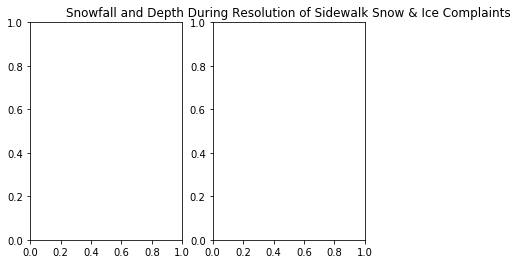

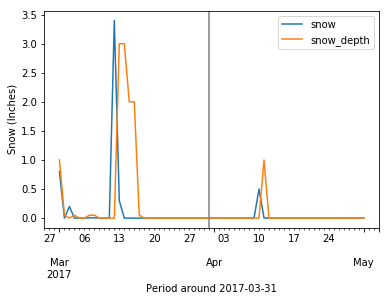

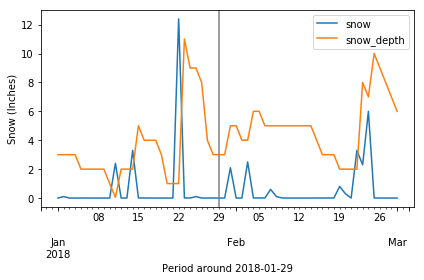

In [27]:
# Plotting snowfall and snow depth around the dates Sidewalk Snow & Ice Complaints were closed.

fig, ax = plt.subplots(1,2)
fig = plt.title('Snowfall and Depth During Resolution of Sidewalk Snow & Ice Complaints')

# Plot for 2017-03-31 timeframe
weather_march17 = df_weather.loc['2017-03-01':'2017-05-01', ['snow', 'snow_depth']]

ax[0] = weather_march17.plot()
ax[0] = plt.axvline(x='2017-03-31', color = 'grey')
ax[0] = plt.xlabel('Period around 2017-03-31')
ax[0] = plt.ylabel('Snow (Inches)')


# Plot for 2018-01-29 timeframe
weather_jan18 = df_weather.loc['2018-01-01':'2018-03-01', ['snow', 'snow_depth']]

ax[1] = weather_jan18.plot()
ax[1] = plt.axvline(x='2018-01-29', color = 'grey')
ax[1] = plt.xlabel('Period around 2018-01-29')
ax[1] = plt.ylabel('Snow (Inches)')

plt.tight_layout()
plt.show()

### Simplifying the dataframe
* Count unique values in each column to determine if they can be grouped or converted to numeric placeholders.

In [28]:
cols = list(df.columns)

In [29]:
# Number of unique entries per column
unique_counts = {col : df[col].nunique() for col in cols}

In [30]:
print(df.subject.nunique(), " Subjects/Departments: ", df.subject.unique())

10  Subjects/Departments:  ['Vehicles and Commuting' 'Sidewalks' 'Public Safety' 'Animal Related'
 'Streets' 'Property' 'Permits / Licensing' 'Health / Environmental'
 'Utilities Related' 'Solid Waste & Recycling']


In [31]:
print(df.reason.nunique(), " Reason Types: ", df.reason.unique())

27  Reason Types:  ['Traffic Control' 'Snow & Ice' 'Graffiti / Clean City' 'Animal Control'
 'Complaints' 'Private Property' 'Street Maintenance'
 'Commercial / Business Licensing' 'Unhealthy Conditions' 'Water'
 'Parking' 'Traffic' 'Garbage & Recycling' 'Construction Inspections'
 'Lighting' 'Biking' 'Sewer & Storm Drain' 'Zoning' 'Inspection'
 'Street Cleaning / Sweeping' 'Fire' 'Police' 'Commercial Property'
 'Traffic Safety' 'Truth in Sale of Housing' 'Green Spaces - Public'
 'Bridges']


In [32]:
print(df.title.nunique(), " Unique Case Titles")
df.title.value_counts(dropna=False).head()

97  Unique Case Titles


Abandoned Vehicle                 14585
Parking Violation Complaint       11895
Exterior Nuisance Complaint        9536
Animal Complaint - Livability      8288
Graffiti complaint / reporting     6495
Name: title, dtype: int64

### Standardizing title/type names

- In 2017, the City removed some call topics related to Bicycle Trails/Lanes, Certificate of Code Compliance Requests and Vacant Buildings. 
- They added topics related to Homeless Encampments, Overflowing Solid Waste (dumpsters), and Street Light Maintenance.  

- In 2018, Street Light topics were changed again and Water Pollution Complaints were removed.
- One Bicycle Trail Improvement Request was added back, as well as a new topic called 'Fire Hydrant Snow Issue'.

## EDA

### Grouping data in different ways

In [33]:
# Could the call reasons be consolidated?
df.groupby(['subject', 'reason'])['title'].count()

subject                  reason                         
Animal Related           Animal Control                     10478
Health / Environmental   Unhealthy Conditions                3788
Permits / Licensing      Commercial / Business Licensing      982
Property                 Commercial Property                  890
                         Construction Inspections             786
                         Private Property                   19782
                         Truth in Sale of Housing              20
                         Zoning                               208
Public Safety            Fire                                 559
                         Graffiti / Clean City               9806
                         Police                               362
Sidewalks                Complaints                          1955
                         Inspection                           672
                         Snow & Ice                          5698
Solid Waste & Recyc

In [34]:
# Could the titles be consolidated?
df.groupby(['reason', 'title'])['title'].count().head(10)

reason                           title                                
Animal Control                   Animal Complaint - Livability            8288
                                 Animal Complaint - Public Health         2190
Biking                           Abandoned/Illegally Parked Bicycle        720
                                 Bicycle Lane Issue                         13
                                 Bicycle Trail Improvement Request           2
                                 Bike Lane Issue - Open311                 112
Bridges                          Bridge Complaint                            7
Commercial / Business Licensing  Licensing Complaint                       982
Commercial Property              Commercial Structure Unsound                7
                                 Commercial/Mixed Conditions Complaint     883
Name: title, dtype: int64

In [35]:
subj_per_day = df.groupby('Date')['subject'].nunique()
subj_per_day.head()

Date
2016-01-01    3
2016-01-02    9
2016-01-03    9
2016-01-04    9
2016-01-05    9
Name: subject, dtype: int64

In [36]:
title_per_day = df.groupby('Date')['title'].nunique()
title_per_day.describe()

count    731.000000
mean      30.771546
std        9.295812
min        4.000000
25%       23.000000
50%       33.000000
75%       38.000000
max       48.000000
Name: title, dtype: float64

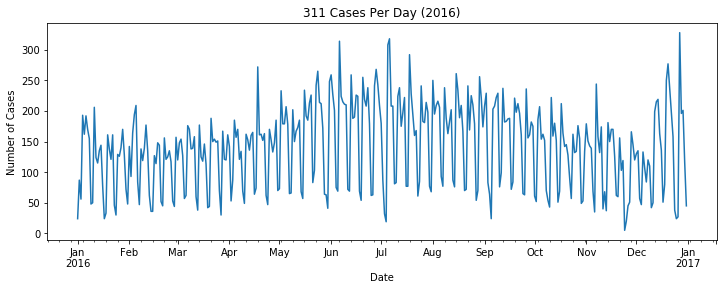

In [37]:
cases_per_day = df.groupby('Date')['subject'].count()
cases_per_day.loc['2016'].plot(title = '311 Cases Per Day (2016)', figsize = (12,4))
plt.ylabel('Number of Cases')
#cases_per_day.loc['2017'].plot()
plt.show()

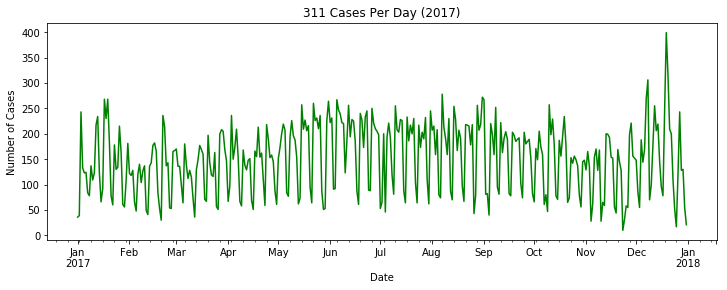

In [38]:
cases_per_day.loc['2017'].plot(title = '311 Cases Per Day (2017)', figsize = (12,4), color = 'green')
plt.ylabel('Number of Cases')
plt.show()

### 311 Volume is higher during the summer than the spring or fall. Call volume spike mid-December through mid-January.

## Which type of cases from 2016 and 2017 are still open?

In [39]:
open_1617 = df[df['status']==1].groupby('title')['reason'].count()
open_1617

title
Bicycle Lane Issue                               1
Commercial Disability Zone                       3
Commercial Food Safety/Sanitation Complaint      8
Commercial/Mixed Conditions Complaint           10
Exterior Nuisance Complaint                     54
General Street Complaint                         1
Graffiti - Open311                              16
Graffiti complaint / reporting                  68
Homeless Encampment                              4
Land Pollution Complaint                         1
Noise Pollution Complaint                        8
Pothole                                          2
Pothole - Open311                                4
RHOD Conditions Complaint                       27
RHOD Tenant Conditions Complaint                41
Residential Conditions Complaint               201
Residential Conditions Complaint Tenant         55
Residential Disability Zone                      3
Street Light - New                               5
Street Light Outage      

In [40]:
open_16 = df[df['status']==1].loc['2016'].groupby('title')['reason'].count()
open_16

Series([], Name: reason, dtype: int64)

There are no open cases from 2016. This leads us to conclude that all cases are eventually closed. However, 32 different types of cases from 2017 are still open. These cases have been open for 7 or more months.

## Do different subjects remain open longer?
We will examine the number of days cases are open by subject. Do some subjects tend to remain open longer? Do some have a wider range and variability? How has this changed from 2016 to 2017?

In [41]:
df.groupby('subject')['days_open'].describe()

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
Animal Related,10478.0,1.571769,2.655160,1.0,1.0,1.0,1.0,59.0
Health / Environmental,3771.0,12.918324,40.890281,1.0,1.0,2.0,4.0,420.0
Permits / Licensing,982.0,3.393075,3.314976,1.0,1.0,2.0,5.0,26.0
Property,21276.0,25.179921,57.297202,1.0,3.0,6.0,16.0,550.0
Public Safety,10643.0,16.738701,22.017228,1.0,2.0,11.0,21.0,254.0
Sidewalks,8325.0,19.487087,24.328571,1.0,2.0,8.0,38.0,290.0
Solid Waste & Recycling,1628.0,4.275184,11.595697,1.0,1.0,2.0,4.0,274.0
Streets,11543.0,10.641514,23.940677,1.0,2.0,4.0,9.0,534.0
Utilities Related,1078.0,6.163265,9.479552,1.0,1.0,3.0,8.0,157.0


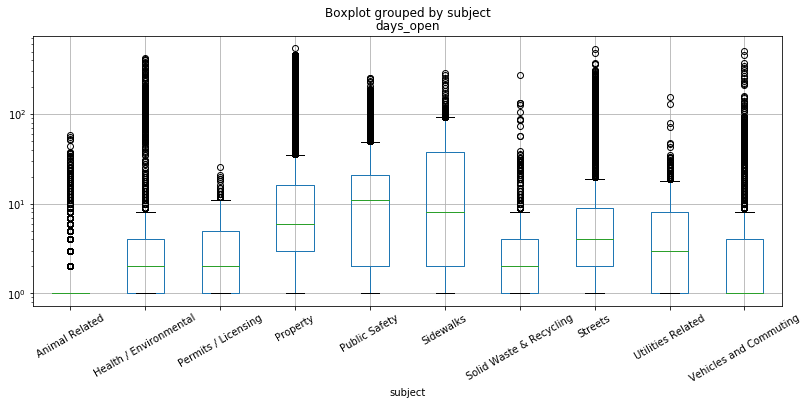

In [42]:
# Visualize boxplots, by subject, of number of days each case is open.
fig, ax = plt.subplots(figsize=(13,5))
plt.suptitle('')
df.boxplot(column=['days_open'], by='subject', ax=ax, rot=30)
plt.yscale('log')
#plt.ylim((-5,100))
plt.show()

* Every subject has a wide range of days until a case is closed. With data points spread from 0 to 549, the y-axis was scaled with the log function. This makes higher data points more visible. However, the 25th percentile is 0 for more than half the subjects, and isn't visible as it lies on the x-axis.
* The 25th to 75th percentile box for Animal Related cases lies entirely at 0. Only the non-zero outliers are visible. This subject has the most consistent close time, and has the 2nd shortest spread. Permits/Licensing has a slightly shorter overall spread.
* There aren't strong patterns correlating mean, spread, and density. 

### How have cases changed from year to year, by subject?

In [43]:
df.loc['2016'].groupby('subject')['days_open'].describe()

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
Animal Related,5292.0,1.649471,2.923997,1.0,1.0,1.0,1.0,56.0
Health / Environmental,1992.0,3.268574,12.722067,1.0,1.0,1.0,3.0,408.0
Permits / Licensing,445.0,2.874157,2.901131,1.0,1.0,2.0,4.0,26.0
Property,10998.0,15.202946,52.384527,1.0,2.0,4.0,8.0,550.0
Public Safety,4794.0,15.021277,17.811856,1.0,4.0,11.0,19.0,187.0
Sidewalks,4117.0,17.080641,26.412034,1.0,3.0,8.0,19.0,290.0
Solid Waste & Recycling,501.0,4.610778,13.236095,1.0,1.0,2.0,5.0,274.0
Streets,5865.0,10.977664,25.303061,1.0,1.0,4.0,9.0,534.0
Utilities Related,502.0,7.450199,8.847596,1.0,1.0,4.0,11.0,80.0


In [44]:
df.loc['2017'].groupby('subject')['days_open'].describe()

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
Animal Related,5186.0,1.492480,2.346963,1.0,1.0,1.0,1.0,59.0
Health / Environmental,1779.0,23.723440,56.061502,1.0,1.0,3.0,7.0,420.0
Permits / Licensing,537.0,3.823091,3.568151,1.0,1.0,3.0,5.0,20.0
Property,10278.0,35.855809,60.327113,1.0,3.0,12.0,32.0,374.0
Public Safety,5849.0,18.146350,24.853988,1.0,1.0,12.0,23.0,254.0
Sidewalks,4208.0,21.841492,21.849004,1.0,1.0,9.0,42.0,130.0
Solid Waste & Recycling,1127.0,4.125998,10.789777,1.0,1.0,2.0,3.0,132.0
Streets,5678.0,10.294294,22.443726,1.0,2.0,4.0,10.0,315.0
Utilities Related,576.0,5.041667,9.869320,1.0,1.0,3.0,6.0,157.0


In [45]:
subj_mean16 = df.loc['2016'].groupby('subject')['days_open'].mean()
subj_mean17 = df.loc['2017'].groupby('subject')['days_open'].mean()
subj_diff = subj_mean17 - subj_mean16
subj_diff

subject
Animal Related             -0.156991
Health / Environmental     20.454866
Permits / Licensing         0.948934
Property                   20.652863
Public Safety               3.125073
Sidewalks                   4.760851
Solid Waste & Recycling    -0.484780
Streets                    -0.683370
Utilities Related          -2.408533
Vehicles and Commuting     -0.204289
Name: days_open, dtype: float64

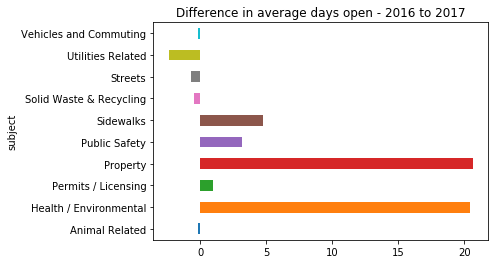

In [46]:
subj_diff.plot(kind = 'barh', title = 'Difference in average days open - 2016 to 2017')
plt.show()

* From 2016 to 2017, Vehicles and Communiting, Streets, Solid Waste & Recycling, Permits / Licensing, and Animal Related cases all had less than a 1 day changing in average (mean) close time.
* At the other end of the spectrum, Property or Health / Environmental cases increased by slightly over 20 days. 

### Property cases - What's driving the increase in average number of days these cases are open?
We will break these cases down into Reason and Title sub-categories. To identify the main drivers, we'll examine the number of cases and the average days open per sub-category.

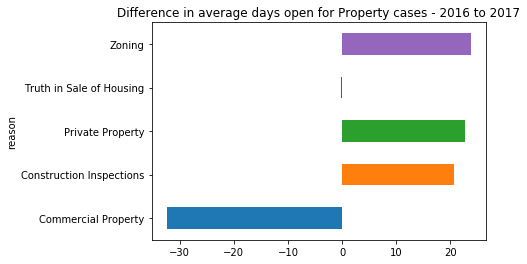

In [47]:
property_mean16 = df[df['subject']=='Property'].loc['2016'].groupby('reason')['days_open'].mean()
property_mean17 = df[df['subject']=='Property'].loc['2017'].groupby('reason')['days_open'].mean()
property_diff =  property_mean17 - property_mean16
property_diff.plot(kind = 'barh', title = 'Difference in average days open for Property cases - 2016 to 2017')
plt.show()

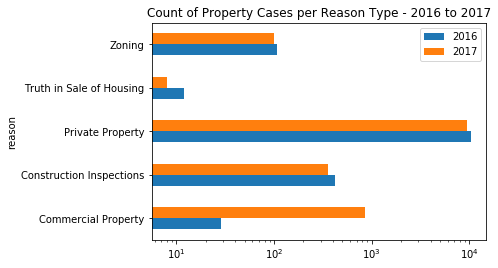

In [48]:
property_count16 = df[df['subject']=='Property'].loc['2016'].groupby('reason')['reason'].count()
property_count17 = df[df['subject']=='Property'].loc['2017'].groupby('reason')['reason'].count()
property_increase =  (property_count17 - property_count16)
property_1617= pd.concat([property_count16, property_count17], axis=1, sort=True)
property_1617.columns = ['2016', '2017']
property_1617.plot(kind = 'barh', title = 'Count of Property Cases per Reason Type - 2016 to 2017')
plt.xscale('log') #View as log scale due to the number of Private Property cases.
plt.show()

In [49]:
m= pd.concat([property_count16, property_count17, property_increase, property_mean16, property_mean17], axis=1, sort=True)
m.columns = ['2016_Count', '2017_Count', 'Difference', '2016_Mean', '2017_Mean']
m

,2016_Count,2017_Count,Difference,2016_Mean,2017_Mean
reason,,,,,
Commercial Property,29,861,832,48.344828,15.977673
Construction Inspections,426,360,-66,9.171362,29.823529
Private Property,10424,9358,-1066,15.493573,38.111595
Truth in Sale of Housing,12,8,-4,1.916667,1.750000
Zoning,107,101,-6,3.411215,27.227723


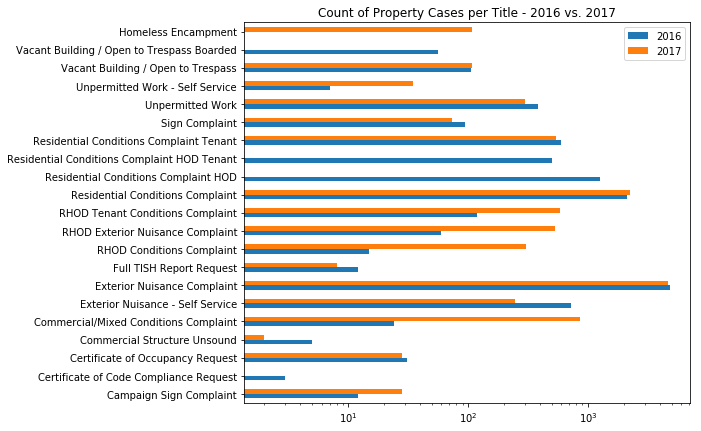

In [50]:
prop_title_mean16 = df[df['subject']=='Property'].loc['2016'].groupby('title')['days_open'].mean()
prop_title_mean17 = df[df['subject']=='Property'].loc['2017'].groupby('title')['days_open'].mean()
prop_title_count16 = df[df['subject']=='Property'].loc['2016'].groupby('title')['reason'].count()
prop_title_count17 = df[df['subject']=='Property'].loc['2017'].groupby('title')['reason'].count()
prop_title_increase =  (prop_title_count17 - prop_title_count16)
prop_title_1617= pd.concat([prop_title_count16, prop_title_count17], axis=1, sort=False)
prop_title_1617.columns = ['2016', '2017']
prop_title_1617.plot(kind = 'barh', title = 'Count of Property Cases per Title - 2016 vs. 2017', figsize = (8,7))
plt.xscale('log') #View as log scale due to the number of Exterior Nuisance cases.
plt.show()


In [51]:
t = pd.concat([prop_title_count16, prop_title_count17, prop_title_increase, prop_title_mean16, prop_title_mean17], axis=1, sort=False)
t.columns = ['2016_Count', '2017_Count', 'Difference', '2016_Mean', '2017_Mean']
t

,2016_Count,2017_Count,Difference,2016_Mean,2017_Mean
Campaign Sign Complaint,12.0,28.0,16.0,3.750000,1.892857
Certificate of Code Compliance Request,3.0,NaN,NaN,1.333333,NaN
Certificate of Occupancy Request,31.0,28.0,-3.0,2.645161,2.714286
Commercial Structure Unsound,5.0,2.0,-3.0,2.000000,2.000000
Commercial/Mixed Conditions Complaint,24.0,859.0,835.0,58.000000,16.010601
Exterior Nuisance - Self Service,723.0,248.0,-475.0,3.975104,27.806452
Exterior Nuisance Complaint,4854.0,4682.0,-172.0,13.030696,44.912489
Full TISH Report Request,12.0,8.0,-4.0,1.916667,1.750000
RHOD Conditions Complaint,15.0,303.0,288.0,71.866667,31.721014
RHOD Exterior Nuisance Complaint,60.0,535.0,475.0,39.000000,9.323364


#### Property cases - The Private Property (Exterior Nuisance) complaints drive the category's increase in average days open.
There are over 10 times as many Private Property cases than any other Property sub-type. These cases overwhelmingly drive the Property group's metrics. Although the number of Private Property calls decrease by around 10% from 2016 to 2017, the average days open increase from 14.5 to 37.1 days. 

Drilling down further, we see that the Exterior Nuisance Complaints make up the largest portion of Private Property cases. Again, we see that these cases have decrease in volume, yet increased in average days open. These account for the Property category's average number of days open to increase by just over 20 days.

#### Adjusting for titles missing or changed from 2016 to 2017.
 - There are only 3 entries for "Certificate of Code Compliance Request" in 2016, none in 2017. We could remove those rows.
 - "RHOD Tenant Conditions Complaint" can be combined with "Residential Conditions Complaint HOD Tenant".
 - "RHOD Conditions Complaint" can be combined with "Residential Conditions Complaint HOD".
 - "Unpermitted Work" can be combined with "Unpermitted Work - Self Service"

### Health/Environmental cases - What's driving the increase in average number of days these cases are open?
We will break these cases down into Title sub-categories. To identify the main drivers, we'll examine the number of cases and the average days open per sub-category.

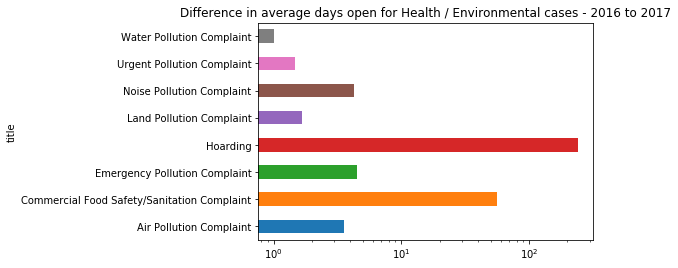

In [52]:
health_mean16 = df[df['subject']=='Health / Environmental'].loc['2016'].groupby('title')['days_open'].mean()
health_mean17 = df[df['subject']=='Health / Environmental'].loc['2017'].groupby('title')['days_open'].mean()
health_diff =  health_mean17 - health_mean16
health_diff.plot(kind = 'barh', title = 'Difference in average days open for Health / Environmental cases - 2016 to 2017')
plt.xscale('log') #View as log scale due to the increase in Hoarding cases.
plt.show()

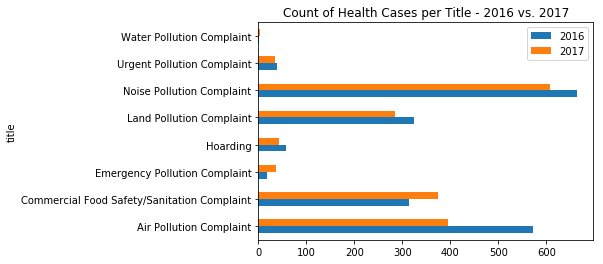

In [53]:
health_count16 = df[df['subject']=='Health / Environmental'].loc['2016'].groupby('title')['days_open'].count()
health_count17 = df[df['subject']=='Health / Environmental'].loc['2017'].groupby('title')['days_open'].count()
health_increase =  (health_count17 - health_count16)
health_1617= pd.concat([health_count16, health_count17], axis=1, sort=False)
health_1617.columns = ['2016', '2017']
health_1617.plot(kind = 'barh', title = 'Count of Health Cases per Title - 2016 vs. 2017')
#plt.xscale('log') #View as log scale due to the number of Noise and Air cases.
plt.show()

In [54]:
h = pd.concat([health_count16, health_count17, health_increase, health_mean16, health_mean17], axis=1, sort=False)
h.columns = ['2016_Count', '2017_Count', 'Difference', '2016_Mean', '2017_Mean']
h

,2016_Count,2017_Count,Difference,2016_Mean,2017_Mean
title,,,,,
Air Pollution Complaint,573,395,-178,2.066318,5.658228
Commercial Food Safety/Sanitation Complaint,314,374,60,5.334395,61.478610
Emergency Pollution Complaint,19,37,18,1.736842,6.216216
Hoarding,58,43,-15,1.000000,242.697674
Land Pollution Complaint,324,284,-40,4.342593,6.010563
Noise Pollution Complaint,664,607,-57,3.162651,7.406919
Urgent Pollution Complaint,38,35,-3,1.368421,2.828571
Water Pollution Complaint,2,4,2,1.000000,2.000000


### What's up with Hoarding?
It took a very long time to resolve Hoarding cases in 2017. What's going on?

In [55]:
hoarding = df[df['title']=='Hoarding']
hoarding16 = df[df['title']=='Hoarding'].loc['2016']
hoarding17 = df[df['title']=='Hoarding'].loc['2017']
#hoarding16[['closed_date', 'days_open', 'x_geom', 'y_geom']]
hoarding17[['closed_date', 'days_open', 'x_geom', 'y_geom']].head()

,,closed_date,days_open,x_geom,y_geom
Date,Time,,,,
2017-01-10,03:17:29,2018-03-05 08:18:00,420.0,-93.256811,44.934139
2017-01-24,02:50:51,2018-03-05 08:20:00,406.0,-93.261635,44.893413
2017-01-31,07:11:36,2018-03-05 08:22:00,399.0,-93.312518,44.913303
2017-02-17,02:49:06,2018-03-05 08:23:00,382.0,-93.261993,44.944729
2017-02-22,08:23:59,2018-03-05 08:24:00,377.0,-93.290611,45.026667


#### Hoarding - These cases were handled differently each year. Where they ever resolved?
In 2016, every Hoarding case was closed the same day it was reported. Does this mean the calls were treated as informational and no action was taken to resolve them?

The opposite pattern in seen in 2017. One case reported on 2017-09-20 was closed after 6 days. However, the other 42 cases were all closed on the same day, 2018-03-05. We can confirm from the reported locations that these are distinct cases, not the same hoarder reported 42 times.  Perhaps the City tried a different method of handling these cases, and found they were still unable to resolve the cases in a significant way.

In [56]:
food = df[df['title']=='Commercial Food Safety/Sanitation Complaint']
food16 = df[df['title']=='Commercial Food Safety/Sanitation Complaint'].loc['2016']
food17 = df[df['title']=='Commercial Food Safety/Sanitation Complaint'].loc['2017']
#food16[['closed_date', 'days_open', 'x_geom', 'y_geom']]
food17[['closed_date', 'days_open', 'x_geom', 'y_geom']].sort_values('days_open', ascending=False).head()

closed_date  days_open     x_geom     y_geom
Date       Time                                                         
2017-07-18 06:02:04 2018-02-05 08:50:36      203.0 -93.271065  44.978339
           10:08:37 2018-02-05 08:49:40      202.0 -93.265840  44.973520
           12:39:27 2018-02-05 08:48:40      202.0 -93.277199  44.987026
2017-07-24 04:59:02 2018-02-05 08:47:36      197.0 -93.288239  44.900291
           07:59:26 2018-02-05 08:46:36      197.0 -93.254413  44.948365

## Change in case volume by subject

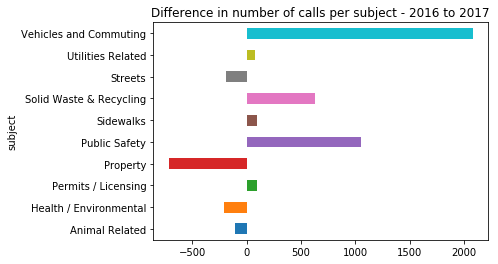

In [57]:
subj_count16 = df.loc['2016'].groupby('subject')['days_open'].count()
subj_count17 = df.loc['2017'].groupby('subject')['days_open'].count()
subj_diff_count = subj_count17 - subj_count16
subj_diff_count.plot(kind = 'barh', title = 'Difference in number of calls per subject - 2016 to 2017')
plt.show()

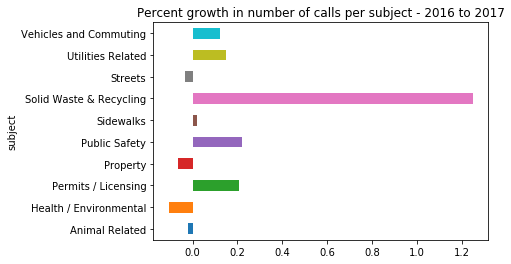

In [58]:
subj_count16 = df.loc['2016'].groupby('subject')['days_open'].count()
subj_count17 = df.loc['2017'].groupby('subject')['days_open'].count()
subj_diff_percent = (subj_count17 - subj_count16)/(subj_count16)
subj_diff_percent.plot(kind = 'barh', title = 'Percent growth in number of calls per subject - 2016 to 2017')
plt.show()

### Solid Waste and Recycling case volume increased by over 120%

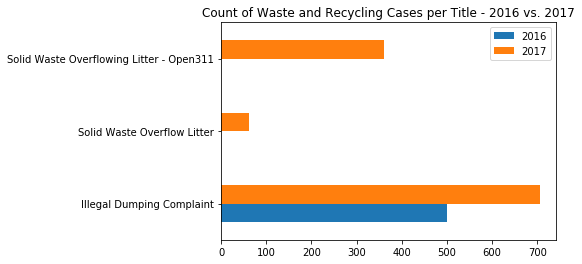

In [59]:
waste_count16 = df[df['subject']=='Solid Waste & Recycling'].loc['2016'].groupby('title')['days_open'].count()
waste_count17 = df[df['subject']=='Solid Waste & Recycling'].loc['2017'].groupby('title')['days_open'].count()
waste_increase =  (health_count17 - health_count16)
waste_1617= pd.concat([waste_count16, waste_count17], axis=1, sort=False)
waste_1617.columns = ['2016', '2017']
waste_1617.plot(kind = 'barh', title = 'Count of Waste and Recycling Cases per Title - 2016 vs. 2017')
#plt.xscale('log') #View as log scale due to the number of Noise and Air cases.
plt.show()

#### Solid Waste and Recycling - Additional categories, Lots of overflowing trash
There was higher volume in every Solid Waste sub-category. In 2017, new case titles were added to report overflowing waste containers (ex. dumpster or public trash bin). Complaints could be filed by phone or via the Open311 app.

In [60]:
#df.groupby(by=[b.index.month, b.index.year])